##Import various python functions and modules that we need.

In [1]:
from pandas import DataFrame
from IPython.display import FileLink

##Pylab namespace and inline plots. Import Rmagic.

In [2]:
%matplotlib inline
%load_ext rpy2.ipython

##Import R libraries we'll use.

In [3]:
%%R
library(phyloseq)
library(ggplot2)
library(foreach)
library(doParallel)
library(gridExtra)
library(dplyr)

foreach: simple, scalable parallel programming from Revolution Analytics
Use Revolution R for scalability, fault tolerance and more.
http://www.revolutionanalytics.com
Loading required package: iterators
Loading required package: parallel
Loading required package: grid

Attaching package: ‘dplyr’

The following object is masked from ‘package:stats’:

    filter

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



##Import data into R. Prune to relevant samples (PS, non-bulk). Get rid of OTUs not observed in at least 25% of samples)

###These files are from the [binning notebook](./OTU_binning.ipynb), [tree notebook](./Tree.ipynb), [merge mappers notebook](./Merge_mappers.ipynb) 

In [4]:
%%R
physeq = import_biom("/var/seq_data/priming_exp/data/otu_table.biom", "/var/seq_data/priming_exp/data/otusn.tree")
sample.data = import_qiime_sample_data("/var/seq_data/priming_exp/data/allsample_metadata_nomock.txt")
physeq = merge_phyloseq(physeq,sample.data)
physeq.md = sample_data(physeq)
physeq.PE = prune_samples((physeq.md$Bulk == 0), physeq)
physeq.PE.snorm = transform_sample_counts(physeq.PE, function(x) x/sum(x))
physeq.PE.thresh = filter_taxa(physeq.PE.snorm, function(x) sum(x > 0) > (0.25 * length(x)), TRUE)
print(physeq.PE.thresh)


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3203 taxa and 395 samples ]
sample_data() Sample Data:       [ 395 samples by 13 sample variables ]
phy_tree()    Phylogenetic Tree: [ 3203 tips and 3202 internal nodes ]


In [5]:
%%R
print(colnames(physeq.md))

 [1] "Sample"       "FractionNum"  "Bulk"         "Control"      "CC"          
 [6] "X100"         "X700"         "H2O"          "Day"          "Density"     
[11] "rep"          "contolVlabel" "Treatment"   


###Calculate pairwise weighted unifrac distances between samples.

In [6]:
%%R
registerDoParallel(cores=20)
wunif.dist = distance(physeq.PE.thresh, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

###Ordinate using weighted unifrac distances with NMDS.

In [7]:
%%R
nmds = ordinate(physeq.PE.thresh, 
                method = "NMDS", 
                distance = wunif.dist)

Run 0 stress 0.08445914 
Run 1 stress 0.08533873 
Run 2 stress 0.08480491 
... procrustes: rmse 0.003676006  max resid 0.05916535 
Run 3 stress 0.09148367 
Run 4 stress 0.1036797 
Run 5 stress 0.1068219 
Run 6 stress 0.1067629 
Run 7 stress 0.0978136 
Run 8 stress 0.09555691 
Run 9 stress 0.09556905 
Run 10 stress 0.08661967 
Run 11 stress 0.09614279 
Run 12 stress 0.1051374 
Run 13 stress 0.08445651 
... New best solution
... procrustes: rmse 0.001019424  max resid 0.01655582 
Run 14 stress 0.08984304 
Run 15 stress 0.08773066 
Run 16 stress 0.08685012 
Run 17 stress 0.08772213 
Run 18 stress 0.09368566 
Run 19 stress 0.1125518 
Run 20 stress 0.09445084 


In [19]:
%%R
df = plot_ordination(physeq.PE.thresh, nmds, justDF = TRUE)
df$Density = as.numeric(as.character(df$Density))

df2 = df %>%
    filter(Sample != c("13C.700.45.03.21", "12C.000.28.03.27"))
head(df2)

        NMDS1        NMDS2           Sample FractionNum Bulk Control CC X100
1 -0.07606223 -0.009323939 12C.700.45.01.24          24    0       1  0    0
2  0.06176971 -0.072874985 12C.700.14.06.14          14    0       1  0    0
3  0.04144789 -0.013864822 12C.100.14.05.18          18    0       1  0    1
4  0.03441894 -0.006618641 12C.700.14.06.05           5    0       1  0    0
5 -0.19050750 -0.012301272 12C.000.14.05.18          18    0       1  1    0
6  0.04583955 -0.033520097 12C.100.14.05.11          11    0       1  0    1
  X700 H2O Day Density rep contolVlabel Treatment
1    1   0  45  1.6783          control    12C700
2    1   0  14  1.7122          control    12C700
3    0   0  14  1.6980          control    12C100
4    1   0  14  1.7559          control    12C700
5    0   0  14  1.6936          control    12C000
6    0   0  14  1.7253          control    12C100


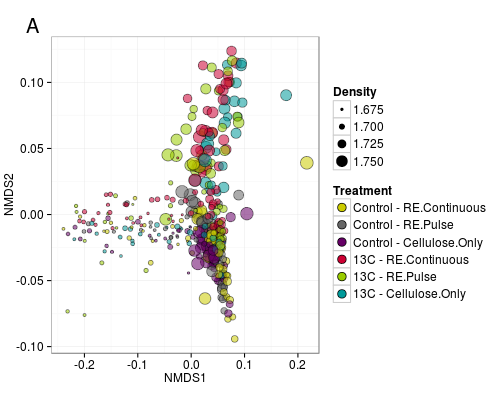

In [20]:
%%R -w 500 -h 400 

colours = c("#660066", "#CCCC00", "#666666", "#009999", "#CC0033", "#99CC00")

p1 = ggplot(df2, aes(x = NMDS1, y = NMDS2)) 

p1 = p1 + geom_point(aes(fill = Treatment, size = Density, alpha = 0.85), shape=21) 

p1 = p1 + scale_fill_manual(values = colours,
                            breaks=c("12C100", "12C700", "12C000", "13C100", "13C700", "13C000"),
                            labels=c("Control - RE.Continuous", "Control - RE.Pulse", "Control - Cellulose.Only",
                                     "13C - RE.Continuous", "13C - RE.Pulse", "13C - Cellulose.Only"))

p1 = p1 + guides(alpha = FALSE)

p1 = p1 + scale_size_area(aesthetics = "Density")

p1 = p1 + ggtitle("A")

p1 = p1 + guides(fill = guide_legend(override.aes = list(size = 4)))
p1 = p1 + guides(size = guide_legend(override.aes = list(fill = "black")))

p1 = p1 + theme_bw()
p1 = p1 + theme(plot.margin = unit(c(1,0,1,0), "lines"))
p1 = p1 + theme(plot.title = element_text(hjust = -0.1, size = 20),
                axis.text = element_text(size = 12),
                axis.title = element_text(size = 12),
                legend.text = element_text(size = 12),
                legend.title = element_text(size = 12))

p1

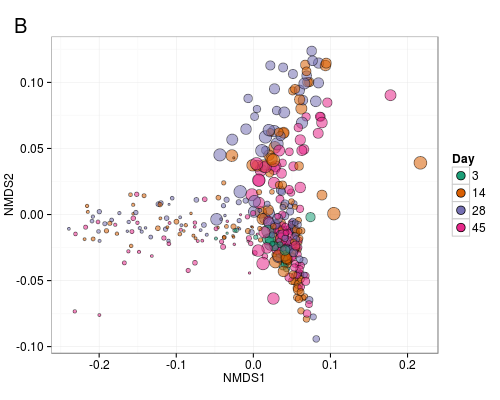

In [21]:
%%R -w 500 -h 400

p2 = ggplot(df2, aes(x = NMDS1, y = NMDS2))

p2 = p2 + geom_point(aes(fill = factor(Day), size = Density, alpha = 0.85), shape=21)

p2 = p2 + scale_fill_brewer(palette="Dark2")

p2 = p2 + guides(alpha = FALSE, size = FALSE)

p2 = p2 + scale_size_area(aesthetics = "Density")

p2 = p2 + ggtitle("B")

p2 = p2 + guides(fill = guide_legend(title = "Day", override.aes = list(size = 4)))

p2 = p2 + theme_bw()
p2 = p2 + theme(plot.margin = unit(c(1,0,1,0), "lines"))
p2 = p2 + theme(plot.title = element_text(hjust = -0.1, size = 20),
                axis.text = element_text(size = 12),
                axis.title = element_text(size = 12),
                legend.text = element_text(size = 12),
                legend.title = element_text(size = 12))

p2

NULL


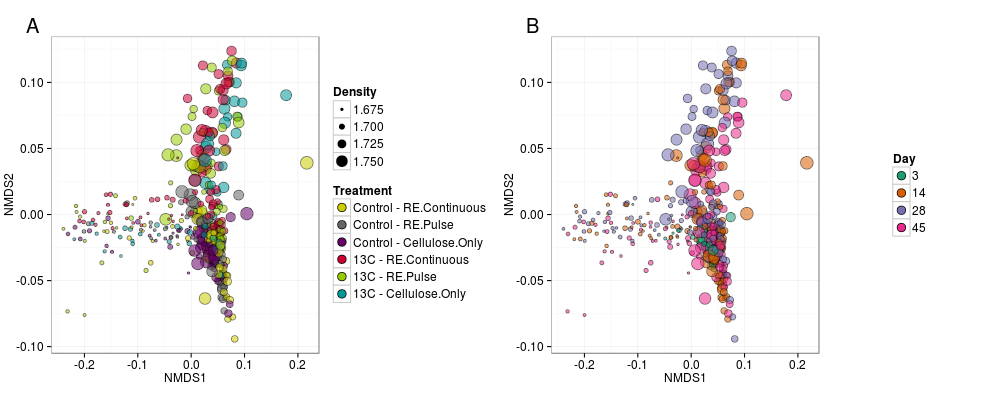

In [22]:
%%R -w 1000 -h 400

gp1 = ggplot_gtable(ggplot_build(p1))
gp2 = ggplot_gtable(ggplot_build(p2))
maxWidth = unit.pmax(gp1$widths[2:5], gp2$widths[2:5])

gp1$widths[2:5] <- maxWidth
gp2$widths[2:5] <- maxWidth

p.combined = grid.arrange(gp1, gp2, ncol = 2)
p.combined

In [23]:
%%R 
pdf("figs/full_ordination.pdf", width = 12, height = 5)
grid.arrange(p1, p2, widths = c(1.3, 1), ncol=2)
dev.off()

png 
  2 


In [24]:
FileLink("figs/full_ordination.pdf")

/home/ashley/priming_exp/figs/full_ordination.pdf

In [25]:
%%R 
png("figs/full_ordination.png", width = 12, height = 5, units = "in", res = 600)
grid.arrange(p1, p2, widths = c(1.3, 1), ncol=2)
dev.off()

png 
  2 


In [26]:
FileLink("figs/full_ordination.png")

/home/ashley/priming_exp/figs/full_ordination.png